In [73]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


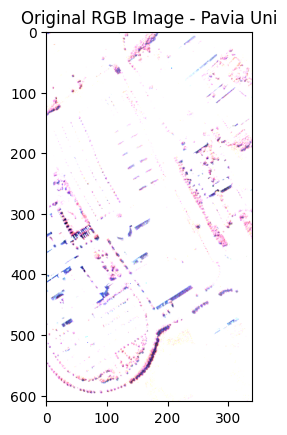

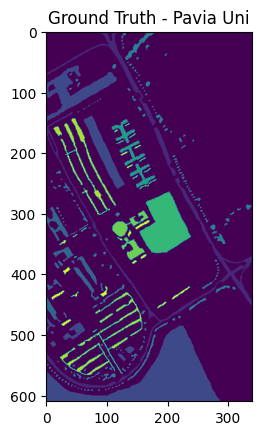

In [74]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Load data from MATLAB file for Pavia Uni
# Access the ground truth variable using the correct key
# Access the hyperspectral data using the correct key

pavia_uni_data = scipy.io.loadmat('/content/drive/MyDrive/PaviaU.mat')
# Print the keys in the loaded dictionary
#print(pavia_uni_data.keys())
#print(pavia_uni_data)
pavia_uni_gt = scipy.io.loadmat('/content/drive/MyDrive/PaviaU_gt.mat')['paviaU_gt']

pavia_uni_data = pavia_uni_data['paviaU']

# Extract RGB bands (29, 19, 9)
rgb_bands = [29, 19, 9]
pavia_uni_rgb = np.stack([pavia_uni_data[:, :, band] for band in rgb_bands], axis=-1)

# Display original RGB image
plt.imshow(pavia_uni_rgb)
plt.title('Original RGB Image - Pavia Uni')
plt.show()

# Display ground truth as an RGB image
plt.imshow(pavia_uni_gt)
plt.title('Ground Truth - Pavia Uni')
plt.show()


In [75]:
from sklearn.model_selection import train_test_split

# Define the size of the tiles
tile_size = 32

# Function to extract tiles from the image
def extract_tiles(image, gt, tile_size):

    tiles_data = []
    tiles_gt = []

    height, width, _ = image.shape

    for y in range(0, height - tile_size + 1, tile_size):
        for x in range(0, width - tile_size + 1, tile_size):

            tile_data = image[y:y+tile_size, x:x+tile_size, :]
            tile_gt = gt[y:y+tile_size, x:x+tile_size]

            tiles_data.append(tile_data)
            tiles_gt.append(tile_gt)

    return tiles_data, tiles_gt

# Extract tiles from the hyperspectral image and ground truth labels
tiles_data, tiles_gt = extract_tiles(pavia_uni_data, pavia_uni_gt, tile_size)

X_train, X_test, y_train, y_test = train_test_split(tiles_data, tiles_gt, test_size=0.2, random_state=42)



In [76]:

# Reshape hyperspectral data for data augmentation and Ensure that X_train_augmented is 4D
X_train_augmented = np.expand_dims(X_train, axis=-1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

X_train_augmented = np.expand_dims(X_train_augmented, axis=-1)

In [82]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall
import keras
import numpy as np

# Function to calculate F1-score
def f1_score(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

# Define U-Net model architecture
def unet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Middle
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4), conv1], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    output = Conv2D(num_classes, 1, activation='softmax')(conv5)

    model = Model(inputs=inputs, outputs=output)

    return model

num_classes = 9

input_shape = (tile_size, tile_size, pavia_uni_data.shape[2])
model = unet_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), f1_score])

# Convert y_train to a NumPy array and subtract 1
y_train_array = np.array(y_train) - 1

# Ensure that values are within the valid range
y_train_array = np.clip(y_train_array, 0, num_classes - 1)

# Convert the modified array back to a list (if necessary)
y_train_onehot = keras.utils.to_categorical(y_train_array, num_classes)

# Ensure X_train_augmented is 4D
X_train_augmented = np.asarray(X_train_augmented)
X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], tile_size, tile_size, pavia_uni_data.shape[2])

# Ensure y_train_onehot is 4D and of type float32
y_train_onehot = np.asarray(y_train_onehot, dtype=np.float32)

# Seed for data augmentation
seed = 42
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Apply the same seed to both X and y generators for consistency
image_generator = datagen.flow(X_train_augmented, batch_size=32, seed=seed)
mask_generator = datagen.flow(y_train_onehot, batch_size=32, seed=seed)

# Use zip to combine both generators into one
train_generator = zip(image_generator, mask_generator)

steps_per_epoch = len(X_train_augmented) // 32

history = model.fit(train_generator, epochs=35, steps_per_epoch=steps_per_epoch)


model.save('semantic_segmentation_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (152, 32, 32, 103) (103 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (152, 32, 32, 9) (9 channels).
  warnings.warn(


Epoch 1/35
4/4 [==============================] - 8s 1s/step - loss: 566.8934 - accuracy: 0.3978 - precision_35: 0.4188 - recall_35: 0.3868 - f1_score: 0.3977
Epoch 2/35
4/4 [==============================] - 6s 2s/step - loss: 82.4893 - accuracy: 0.5835 - precision_35: 0.6138 - recall_35: 0.5673 - f1_score: 0.5727
Epoch 3/35
4/4 [==============================] - 5s 1s/step - loss: 28.5652 - accuracy: 0.5696 - precision_35: 0.5963 - recall_35: 0.5537 - f1_score: 0.5752
Epoch 4/35
4/4 [==============================] - 6s 2s/step - loss: 18.8664 - accuracy: 0.7074 - precision_35: 0.7400 - recall_35: 0.6884 - f1_score: 0.7035
Epoch 5/35
4/4 [==============================] - 5s 1s/step - loss: 9.6923 - accuracy: 0.6182 - precision_35: 0.6546 - recall_35: 0.5999 - f1_score: 0.6130
Epoch 6/35
4/4 [==============================] - 5s 1s/step - loss: 6.6595 - accuracy: 0.6432 - precision_35: 0.6758 - recall_35: 0.6230 - f1_score: 0.6366
Epoch 7/35
4/4 [==============================] - 7s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 1s 72ms/step


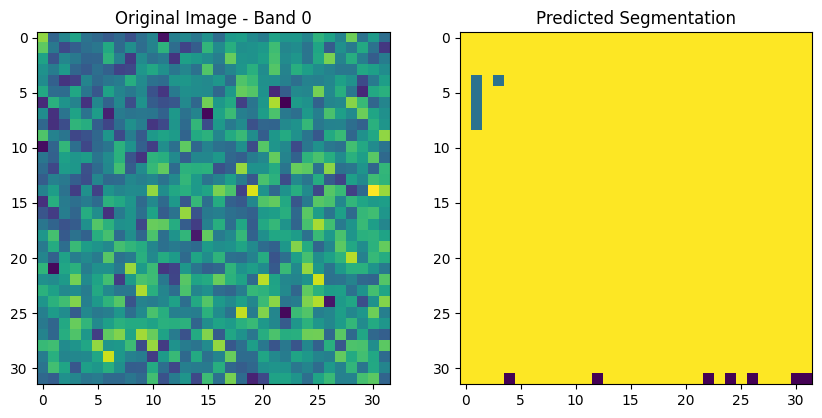

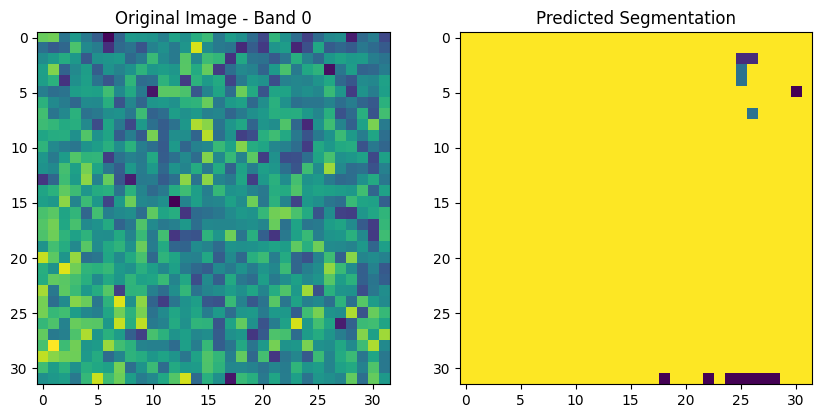

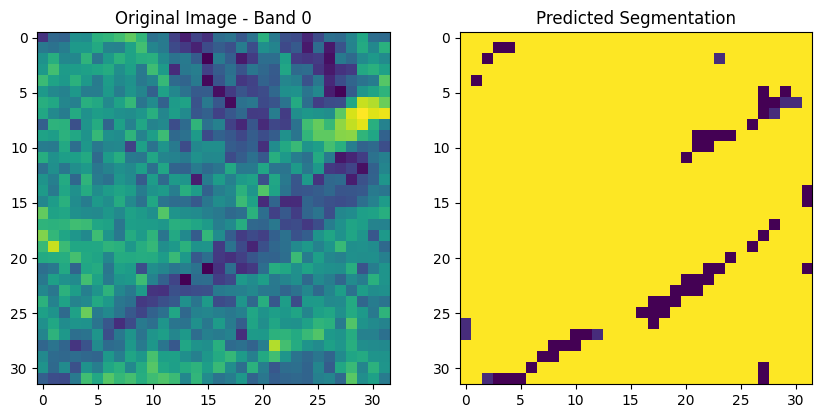

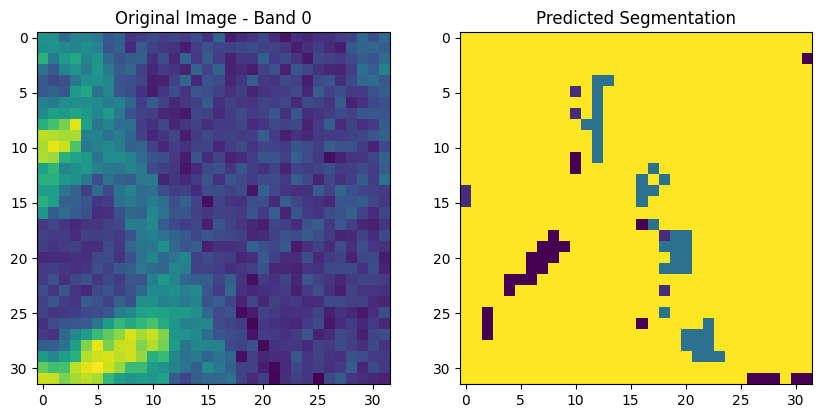

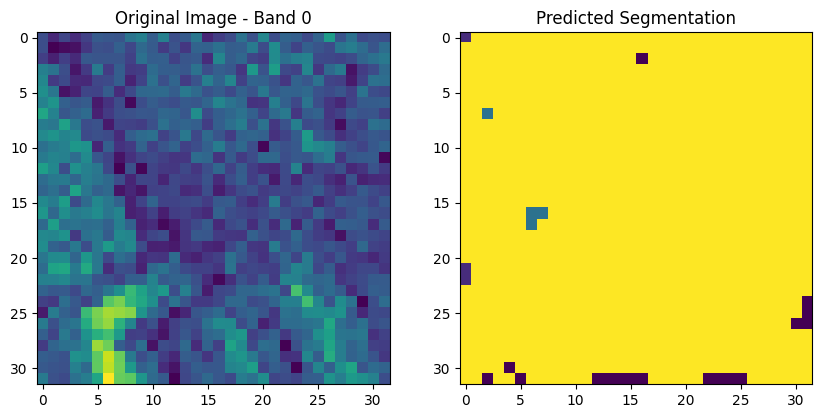

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import confusion_matrix, classification_report


model = load_model('semantic_segmentation_model.h5', custom_objects={'f1_score': f1_score})

# Get predictions on the normalized test set
predictions = model.predict(X_test_normalized)

# Visualize some sample predictions
num_samples_to_visualize = 5
for i in range(num_samples_to_visualize):
    plt.figure(figsize=(10, 5))

    # Display original image (select a specific spectral band, e.g., 0)
    spectral_band_index = 0
    plt.subplot(1, 2, 1)
    plt.imshow(X_test_normalized[i, :, :, spectral_band_index], cmap='viridis')
    plt.title(f'Original Image - Band {spectral_band_index}')

    # Display predicted segmentation
    plt.subplot(1, 2, 2)
    plt.imshow(np.argmax(predictions[i], axis=-1), cmap='viridis')
    plt.title('Predicted Segmentation')

    plt.show()


2/2 [==============================] - 1s 76ms/step


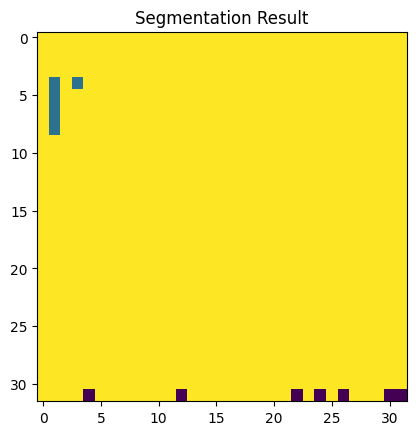

Confusion Matrix:
[[  657   147     0   324     0     0     0     0 30784     0]
 [    2     2     0     0     0     0     0     0  1166     0]
 [   24     0     0     0     0     0     0     0  2583     0]
 [   13     1     0     0     0     0     0     0   573     0]
 [    8    12     0    83     0     0     0     0   616     0]
 [    0     0     0     0     0     0     0     0   191     0]
 [    6     3     0     3     0     0     0     0  1003     0]
 [    2     1     0     0     0     0     0     0   282     0]
 [    6     1     0     0     0     0     0     0   144     0]
 [    2     1     0     0     0     0     0     0   272     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.02      0.04     31912
           1       0.01      0.00      0.00      1170
           2       0.00      0.00      0.00      2607
           3       0.00      0.00      0.00       587
           4       0.00      0.00      0.00       719
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

model = load_model('semantic_segmentation_model.h5', custom_objects={'f1_score': f1_score})
# Assuming X_test is a list of tiles, stack them into a single tensor
X_test = np.stack(X_test, axis=0)

mean_train = np.mean(X_train_augmented)
std_train = np.std(X_train_augmented)

X_test_normalized = (X_test - mean_train) / std_train

# Ensure X_test_normalized is 4D
X_test_normalized = np.expand_dims(X_test_normalized, axis=-1)

predictions = model.predict(X_test_normalized)

# Visualize segmentation results
plt.imshow(np.argmax(predictions[0], axis=-1), cmap='viridis')
plt.title('Segmentation Result')
plt.show()

# Display confusion matrix and classification report
y_pred = np.argmax(predictions, axis=-1).flatten()
y_true = np.concatenate(y_test, axis=0).flatten()

conf_matrix = confusion_matrix(y_true, y_pred)
classification_report_str = classification_report(y_true, y_pred)

print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(classification_report_str)
